# Time-Series Forecasting | Corporación Favorita Grocery Sales
## Section 5: Prophet
### 1 - Notebook Overview

This notebook implements the **Prophet** forecasting model to predict total daily sales for the `Guayas` region. **Prophet** is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. Why **Prophet**?

- **Robustness to Missing Data:** Unlike **SARIMA**, **Prophet** does not require a perfectly continuous time series to function, making it resilient to the data gaps identified in the early stages of this project.
- **Holiday Integration:** It allows for the explicit inclusion of Ecuadorian national holidays, which were identified as significant drivers of sales variance during the EDA.
- **Automatic Change-Point Detection:** **Prophet** can automatically detect shifts in trends (e.g., a sudden increase in regional sales growth), which helps address the "momentum" issues where the **SARIMA** model struggled.

By using **Prophet** as the third and final model, I can evaluate whether a "Business-Scale" forecasting tool offers a better balance of accuracy and interpretability than the "Micro" approach of **XGBoost** or the "Classic" approach of **SARIMA**.

---

### 2 - Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import time

# Data visualization
import matplotlib.pyplot as plt

# Machine learning libraries
from prophet import Prophet

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/Users/annie/Repos/project-ml-favorita-sales-forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3 - Data Ingestion

In [2]:
# Load training data
df_train = pd.read_pickle('../data/train_models.pkl')

# # Check shape
print(f"Shape: {df_train.shape}")

# Check memory usage
memory_gb = df_train.memory_usage(deep=True).sum() / (1024**3)
print(f"Memory: {memory_gb:.2f} GB")

# Check column data types
print("\nColumn Data Types:")
print("-" * 50)
print(df_train.dtypes)

# Check for missing values
print("\nMissing Values per Column:")
print("-" * 50)
display(df_train.isnull().sum())

# Display first 3 rows
print("\nDataset Preview:")
print("-" * 50)
display(df_train.head(3))

Shape: (18680367, 15)
Memory: 1.67 GB

Column Data Types:
--------------------------------------------------
date                  datetime64[ns]
store_nbr                      int32
item_nbr                       int32
unit_sales                   float64
onpromotion                    int32
year                           int32
month                          int32
day                            int32
day_of_week                    int32
is_holiday                     int32
unit_sales_7d_avg            float64
unit_sales_14d_avg           float64
unit_sales_lag_1             float64
unit_sales_lag_7             float64
unit_sales_lag_30            float64
dtype: object

Missing Values per Column:
--------------------------------------------------


date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion           0
year                  0
month                 0
day                   0
day_of_week           0
is_holiday            0
unit_sales_7d_avg     0
unit_sales_14d_avg    0
unit_sales_lag_1      0
unit_sales_lag_7      0
unit_sales_lag_30     0
dtype: int64


Dataset Preview:
--------------------------------------------------


,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,is_holiday,unit_sales_7d_avg,unit_sales_14d_avg,unit_sales_lag_1,unit_sales_lag_7,unit_sales_lag_30
30,2013-07-08,24,96995,0.0,0,2013,7,8,0,0,0.0,0.0,0.0,0.0,2.0
31,2013-07-09,24,96995,0.0,0,2013,7,9,1,0,0.0,0.0,0.0,0.0,0.0
32,2013-07-10,24,96995,0.0,0,2013,7,10,2,0,0.0,0.0,0.0,0.0,0.0


### 4 - Time-Series Slicing

**Prophet** requires a univariate DataFrame with two specific column names:

- `ds` for the date and 
- `y` for the target variable (`unit_sales`)

I will aggregate the item-level data to a daily total for the `Guayas` region and then slice it into the same training and validation periods used in the previous notebooks.

In [3]:
# Aggregate to daily totals for the region
df_daily = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Prophet expects columns named 'ds' (date) and 'y' (target)
df_prophet = df_daily.rename(columns={'date': 'ds', 'unit_sales': 'y'})

# Define the forecast dates
start_date = '2014-01-01'
end_date = '2014-03-31'

# Create training dataset of 2013 data
train_data = df_prophet[df_prophet['ds'] < start_date].copy()

# Create validation dataset for first quarter 2014 data
val_data = df_prophet[(df_prophet['ds'] >= start_date) & (df_prophet['ds'] <= end_date)].copy()

# Check shapes and date ranges
print("TRAINING DATASET")
print("-" * 50)
print(f"Shape: {train_data.shape}")
print("Start date:", train_data['ds'].min().date())
print("End date:", train_data['ds'].max().date())
print("Preview:")
display(train_data.head(3))
print("\nVALIDATION DATASET")
print("-" * 50)
print(f"Shape: {val_data.shape}")
print("Start date:", val_data['ds'].min().date())
print("End date:", val_data['ds'].max().date())
print("Preview:")
display(val_data.head(3))

TRAINING DATASET
--------------------------------------------------
Shape: (334, 2)
Start date: 2013-02-01
End date: 2013-12-31
Preview:


,ds,y
0,2013-02-01,15.0
1,2013-02-02,14.0
2,2013-02-03,40.0



VALIDATION DATASET
--------------------------------------------------
Shape: (90, 2)
Start date: 2014-01-01
End date: 2014-03-31
Preview:


,ds,y
334,2014-01-01,7.0
335,2014-01-02,1059.0
336,2014-01-03,794.0


### 5 - Prophet Model Training

**Prophet** is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. For this regional forecast, I will enable **weekly seasonality** and incorporate **Ecuadorian national holidays** to account for the sales spikes typical of the `Guayas` region.

In [4]:
# Initialize the Prophet model with specified parameters
model = Prophet(
    # Growth parameters
    growth='linear',  # Linear for unbounded growth

    # Change point parameters
    changepoint_prior_scale=0.01,  # Flexibility of the trend (0.001-0.5, higher = more flexible)
    n_changepoints=25,  # Number of potential changepoints
    changepoint_range=0.8,  # Proportion of data in which changepoints are allowed

    # Seasonality parameters
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',  # Seasonal fluctuations are constant over time
    seasonality_prior_scale=10.0,  # Flexibility of seasonality (1-20, higher = more flexible)
    
    # Holiday parameters
    holidays=None,  # Will add Ecuadorian holidays if needed
    holidays_prior_scale=10.0,

    # Uncertainty parameters
    interval_width=0.95,  # 95% confidence interval
    mcmc_samples=0,  # No MCMC sampling for faster fitting, set >0 for full Bayesian inference

    # Miscellaneous parameters
    uncertainty_samples=1000,  # Samples for uncertainty intervals
    stan_backend=None  # Use default Stan backend
)

# Print model configuration
print("Prophet Model Configuration:")
print("-" * 50)
print(f'Growth type: {model.growth}')
print(f'Seasonality mode: {model.seasonality_mode}')
print(f'Yearly seasonality: {model.yearly_seasonality}')
print(f'Weekly seasonality: {model.weekly_seasonality}')
print(f'Changepoint prior scale: {model.changepoint_prior_scale}')
print(f'Seasonality prior scale: {model.seasonality_prior_scale}')
print(f'Confidence interval: {model.interval_width * 100}%')

Prophet Model Configuration:
--------------------------------------------------
Growth type: linear
Seasonality mode: additive
Yearly seasonality: True
Weekly seasonality: True
Changepoint prior scale: 0.01
Seasonality prior scale: 10.0
Confidence interval: 95.0%


In [5]:
# Add monthly seasonality that is useful for retail data
model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=5  # Number of Fourier components (higher = more flexible)
)

# Confirm monthly seasonality added
print("\nAdded Monthly Seasonality:")
print("-" * 50)
print('Period:', 30.5, 'days')
print('Fourier order:', 5)


Added Monthly Seasonality:
--------------------------------------------------
Period: 30.5 days
Fourier order: 5


In [6]:
# Record the start time
start_time = time.time()

# Fit the model to the training data
model.fit(train_data)

# Record the end time
end_time = time.time()

# Calculate training time
training_duration = end_time - start_time

20:09:50 - cmdstanpy - INFO - Chain [1] start processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing


### 6 - Forecasting

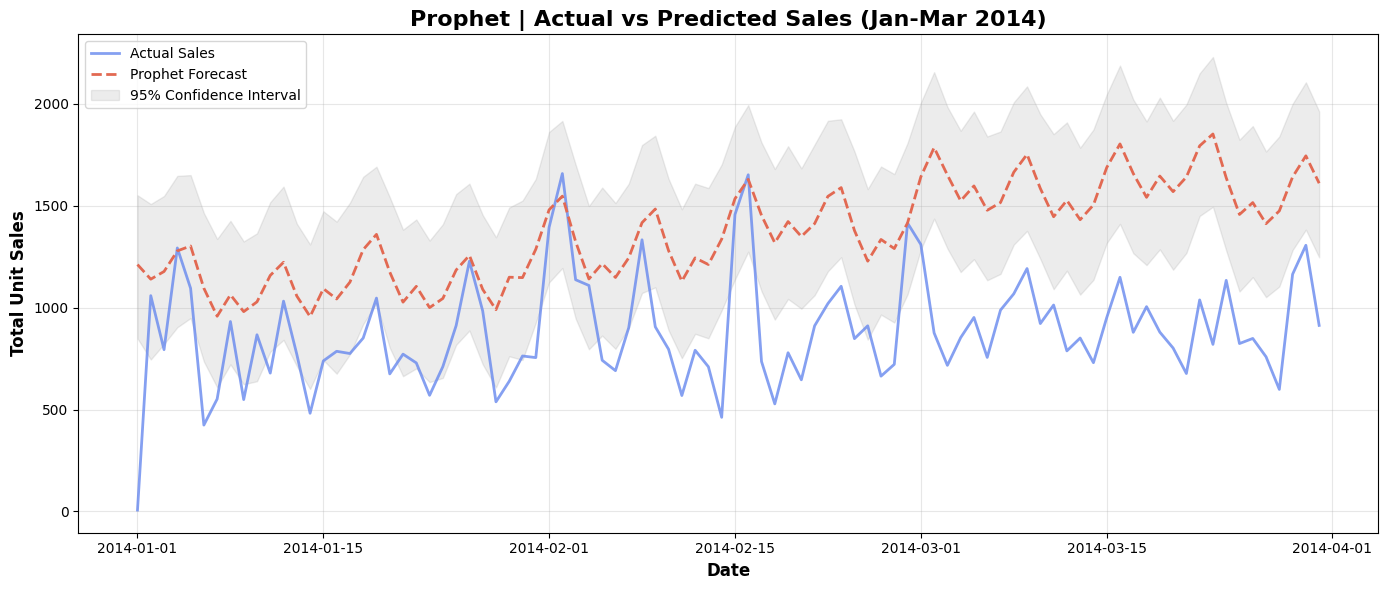

In [7]:
# Create a future dataframe for the 90 days of Q1 2014
future = model.make_future_dataframe(periods=90)

# Predict (returns 'yhat' for the entire timeline)
forecast = model.predict(future)

# Filter for the validation period (Q1 2014) to align with val_data
mask = (forecast['ds'] >= '2014-01-01') & (forecast['ds'] <= '2014-03-31')
y_pred_series = forecast.loc[mask, 'yhat']
val_dates = val_data['ds']
y_actual = val_data['y']

# Plot Actual vs Predicted with Confidence Intervals
plt.figure(figsize=(14, 6))
plt.plot(val_dates, y_actual, label='Actual Sales', color='#6788ee', linewidth=2, alpha=0.8)
plt.plot(val_dates, y_pred_series, label='Prophet Forecast', color='#e26952', linewidth=2, linestyle='--')

# Shading the uncertainty intervals
plt.fill_between(
    val_dates, 
    forecast.loc[mask, 'yhat_lower'], 
    forecast.loc[mask, 'yhat_upper'], 
    color='gray', alpha=0.15, label='95% Confidence Interval'
)

# Add titles and labels
plt.title('Prophet | Actual vs Predicted Sales (Jan-Mar 2014)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Unit Sales', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
plt.savefig('../visualizations/prophet-actual-vs-predicted.png', dpi=300)

# Display the plot
plt.show()

### 7 - Evaluation Metrics

In [8]:
# Calculate evaluation metrics
mae = mean_absolute_error(val_data['y'], y_pred_series)
mse = mean_squared_error(val_data['y'], y_pred_series)
rmse = np.sqrt(mse)
bias = np.mean(y_pred_series - val_data['y'])
r2 = r2_score(val_data['y'], y_pred_series)

print("Prophet Model Evaluation Metrics")
print("-" * 50)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Bias: {bias:.2f}")
print(f"R-Squared Score: {r2:.2f}")

# Print training time
minutes = int(training_duration // 60)
seconds = int(training_duration % 60)
print(f"Training Time: {minutes:02d}:{seconds:02d}")

Prophet Model Evaluation Metrics
--------------------------------------------------
Mean Absolute Error (MAE): 486.84
Mean Squared Error (MSE): 301675.91
Root Mean Squared Error (RMSE): 549.25
Bias: 483.55
R-Squared Score: -3.21
Training Time: 00:00


### 8 - Conclusion

The **Prophet** model’s performance results provide a clear look at how automated time-series tools handle data transitions:

- **Metric Analysis:** The **Mean Absolute Error (MAE) of 486.84** and a high **positive Bias of 483.55** indicate a "structural" over-prediction.
- **Accuracy:** The **R-Squared of -3.21** reveals that a horizontal line representing the average sales would be more accurate than this model's specific trend.
- **The "One-Year" Limitation:** Because **Prophet** is a decomposable model, it relies heavily on historical cycles. With only 12 months of 2013 data, the model misinterpreted year-end holiday growth as permanent momentum.
- **2014 Reality:** When actual sales in Q1 2014 returned to a lower baseline, the model stayed "anchored" to its 2013 assumptions, causing the forecast to float consistently above the true values.

Comparing the results of all three modeling approaches, I can draw the following conclusions for the Favorita Sales project:

- **The Winner:** **XGBoost** is the superior choice for this dataset. Its ability to process "Micro" features (item-level promotions, store metadata, and specific dates) allowed it to adapt to volatility that traditional models could not see.
- **Macro vs. Micro:** While **Prophet** and **SARIMA** attempted to model the "Macro" trend of the `Guayas` region, they both suffered from significant lag and over-prediction bias during the 2014 transition.

In highly volatile retail environments, feature-rich machine learning models outperform univariate time-series models that rely solely on historical timestamps. The item-level granularity provided by **XGBoost** is essential for capturing the true drivers of sales.